Hey fellas,

Welcome to second asignment series. Here we are gonna use Backprop to correct errors. The first task is to go through this complete code and understand its working.  Then go at the end of code and see the XOR implementation. Something is missing over there. Try to rectify the code( either augment the given code or write your own). Also mention what was missing  though in a text box. I would appreciate if you guys share the google colab notebook link directly to amritansh.48@gmail.com.

In [1]:
import random
import math

In [2]:
class NeuralNetwork:
    LEARNING_RATE = 0.05

    def update_learning_rate(self, new_rate):
      self.LEARNING_RATE = new_rate


    def __init__(self, num_inputs, num_hidden, num_outputs, hidden_layer_weights = None, hidden_layer_bias = None, output_layer_weights = None, output_layer_bias = None):
        self.num_inputs = num_inputs

        self.hidden_layer = NeuronLayer(num_hidden, hidden_layer_bias)
        self.output_layer = NeuronLayer(num_outputs, output_layer_bias)

        self.init_weights_from_inputs_to_hidden_layer_neurons(hidden_layer_weights)
        self.init_weights_from_hidden_layer_neurons_to_output_layer_neurons(output_layer_weights)

    def init_weights_from_inputs_to_hidden_layer_neurons(self, hidden_layer_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_weights:
                    self.hidden_layer.neurons[h].weights.append(random.random())
                else:
                    self.hidden_layer.neurons[h].weights.append(hidden_layer_weights[weight_num])
                weight_num += 1

    def init_weights_from_hidden_layer_neurons_to_output_layer_neurons(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(random.random())
                else:
                    self.output_layer.neurons[o].weights.append(output_layer_weights[weight_num])
                weight_num += 1
                
    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer')
        self.hidden_layer.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')

    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs)
        return self.output_layer.feed_forward(hidden_layer_outputs)
      
    
    # Uses online learning, ie updating the weights after each training case
    def train(self, training_inputs, training_outputs):
        self.feed_forward(training_inputs)

        # 1. Output neuron deltas
        pd_errors_wrt_output_neuron_total_net_input = [0] * len(self.output_layer.neurons)
        for o in range(len(self.output_layer.neurons)):

            # ∂E/∂zⱼ
            pd_errors_wrt_output_neuron_total_net_input[o] = self.output_layer.neurons[o].calculate_pd_error_wrt_total_net_input(training_outputs[o])

        # 2. Hidden neuron deltas
        pd_errors_wrt_hidden_neuron_total_net_input = [0] * len(self.hidden_layer.neurons)
        for h in range(len(self.hidden_layer.neurons)):

            # We need to calculate the derivative of the error with respect to the output of each hidden layer neuron
            # dE/dyⱼ = Σ ∂E/∂zⱼ * ∂z/∂yⱼ = Σ ∂E/∂zⱼ * wᵢⱼ
            d_error_wrt_hidden_neuron_output = 0
            for o in range(len(self.output_layer.neurons)):
                d_error_wrt_hidden_neuron_output += pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].weights[h]

            # ∂E/∂zⱼ = dE/dyⱼ * ∂zⱼ/∂
            pd_errors_wrt_hidden_neuron_total_net_input[h] = d_error_wrt_hidden_neuron_output * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_input()

        # 3. Update output neuron weights
        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):

                # ∂Eⱼ/∂wᵢⱼ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢⱼ
                pd_error_wrt_weight = pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].calculate_pd_total_net_input_wrt_weight(w_ho)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.output_layer.neurons[o].weights[w_ho] -= self.LEARNING_RATE * pd_error_wrt_weight

        # 4. Update hidden neuron weights
        for h in range(len(self.hidden_layer.neurons)):
            for w_ih in range(len(self.hidden_layer.neurons[h].weights)):

                # ∂Eⱼ/∂wᵢ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢ
                pd_error_wrt_weight = pd_errors_wrt_hidden_neuron_total_net_input[h] * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_weight(w_ih)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.hidden_layer.neurons[h].weights[w_ih] -= self.LEARNING_RATE * pd_error_wrt_weight
                
                
    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].calculate_error(training_outputs[o])
        return total_error



In [3]:
class NeuronLayer:
    def __init__(self, num_neurons, bias):

        # Every neuron in a layer shares the same bias
        self.bias = bias if bias else random.random()

        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

In [4]:
class Neuron:
    def __init__(self, bias):
        self.bias = bias
        self.weights = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    # Apply the logistic function to squash the output of the neuron

    def squash(self, total_net_input):
        return 1 / (1 + math.exp(-total_net_input))

    # Determine how much the neuron's total input has to change to move closer to the expected output
    #
    # Now that we have the partial derivative of the error with respect to the output (∂E/∂yⱼ) and
    # the derivative of the output with respect to the total net input (dyⱼ/dzⱼ) we can calculate
    # the partial derivative of the error with respect to the total net input.
    # This value is also known as the delta (δ) [1]
    # δ = ∂E/∂zⱼ = ∂E/∂yⱼ * dyⱼ/dzⱼ
    #
    # Manoj : ∂E/∂yⱼ -> Correspond the derivatives of output layer, But ∂yⱼ itself is dependent on output from hidden layer, i.e ∂yⱼ/∂zⱼ
    #       : So, ∂E/∂zⱼ = ∂E/∂yⱼ * dyⱼ/dzⱼ  (here it is not partial detivatives because there is only one variable)

    def calculate_pd_error_wrt_total_net_input(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.calculate_pd_total_net_input_wrt_input();

    # The error for each neuron is calculated by the Mean Square Error method:
    # Manoj: Just MSE calculation
    def calculate_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    # The partial derivate of the error with respect to actual output then is calculated by:
    # = 2 * 0.5 * (target output - actual output) ^ (2 - 1) * -1
    # = -(target output - actual output)
    #
    # The Wikipedia article on backpropagation [1] simplifies to the following, but most other learning material does not [2]
    # = actual output - target output
    #
    # Alternative, you can use (target - output), but then need to add it during backpropagation [3]
    #
    # Note that the actual output of the output neuron is often written as yⱼ and target output as tⱼ so:
    # = ∂E/∂yⱼ = -(tⱼ - yⱼ)
    def calculate_pd_error_wrt_output(self, target_output):
        return -(target_output - self.output)

    # The total net input into the neuron is squashed using logistic function to calculate the neuron's output:
    # yⱼ = φ = 1 / (1 + e^(-zⱼ))
    # Note that where ⱼ represents the output of the neurons in whatever layer we're looking at and ᵢ represents the layer below it
    #
    # The derivative (not partial derivative since there is only one variable) of the output then is:
    # dyⱼ/dzⱼ = yⱼ * (1 - yⱼ)
    def calculate_pd_total_net_input_wrt_input(self):
        return self.output * (1 - self.output)

    # The total net input is the weighted sum of all the inputs to the neuron and their respective weights:
    # = zⱼ = netⱼ = x₁w₁ + x₂w₂ ...
    #
    # The partial derivative of the total net input with respective to a given weight (with everything else held constant) then is:
    # = ∂zⱼ/∂wᵢ = some constant + 1 * xᵢw₁^(1-0) + some constant ... = xᵢ
    def calculate_pd_total_net_input_wrt_weight(self, index):
        return self.inputs[index]


In [5]:
# Example 1

nn = NeuralNetwork(2, 2, 2, hidden_layer_weights=[0.15, 0.2, 0.25, 0.3], hidden_layer_bias=0.35, output_layer_weights=[0.4, 0.45, 0.5, 0.55], output_layer_bias=0.6)
for i in range(100):
    nn.train([0.05, 0.1], [0.01, 0.99])
    print(i, round(nn.calculate_total_error([[[0.05, 0.1], [0.01, 0.99]]]), 9))


0 0.297639963
1 0.29690735
2 0.296173281
3 0.295437769
4 0.294700824
5 0.29396246
6 0.293222689
7 0.292481524
8 0.291738978
9 0.290995064
10 0.290249795
11 0.289503187
12 0.288755252
13 0.288006005
14 0.287255461
15 0.286503634
16 0.285750539
17 0.284996193
18 0.284240609
19 0.283483804
20 0.282725795
21 0.281966596
22 0.281206226
23 0.2804447
24 0.279682035
25 0.278918249
26 0.27815336
27 0.277387384
28 0.27662034
29 0.275852246
30 0.275083121
31 0.274312982
32 0.273541849
33 0.272769742
34 0.271996678
35 0.271222678
36 0.270447761
37 0.269671948
38 0.268895259
39 0.268117713
40 0.267339332
41 0.266560137
42 0.265780148
43 0.264999386
44 0.264217873
45 0.263435631
46 0.262652682
47 0.261869047
48 0.261084749
49 0.260299809
50 0.259514251
51 0.258728098
52 0.257941372
53 0.257154096
54 0.256366294
55 0.255577988
56 0.254789204
57 0.253999964
58 0.253210292
59 0.252420212
60 0.251629749
61 0.250838927
62 0.25004777
63 0.249256303
64 0.248464551
65 0.247672538
66 0.246880291
67 0.2460878

In [6]:
# XOR example - Homework. Correct the implemnation to run XOR problem with higher accuracy, Mention and add whats missing:

training_sets = [
    [[0, 0], [0]],
    [[0, 1], [1]],
    [[1, 0], [1]],
    [[1, 1], [0]]
]

nn = NeuralNetwork(len(training_sets[0][0]), 5, len(training_sets[0][1]))
for i in range(100):
    training_inputs, training_outputs = random.choice(training_sets)
    nn.train(training_inputs, training_outputs)
    print(i, nn.calculate_total_error(training_sets))

0 0.8916979041847
1 0.8917391697743409
2 0.8917803898271407
3 0.8918116360659595
4 0.891173809756996
5 0.8905915281078125
6 0.8899415233497738
7 0.8899744649254282
8 0.8900176336374245
9 0.8900505040422315
10 0.8900833434419049
11 0.8894895435364756
12 0.8895229103030394
13 0.8895665883176556
14 0.8889062939057667
15 0.8882393089061077
16 0.8882844490488067
17 0.8876111400578298
18 0.8876463180984037
19 0.8876921439275899
20 0.887737915753995
21 0.8877729703017749
22 0.8871544773566769
23 0.8872008778140774
24 0.8872472231642746
25 0.8866230380540994
26 0.8866700640852963
27 0.885980388105847
28 0.8853424225924522
29 0.8853909782430691
30 0.8847465491241169
31 0.8847958275709162
32 0.8841448451325384
33 0.8834866643367372
34 0.882764432061123
35 0.882804579247547
36 0.8821314983048982
37 0.8821723259790117
38 0.8822248056634864
39 0.8815452277930099
40 0.8808028935064628
41 0.8801072995662396
42 0.8801503575811984
43 0.8801933669998314
44 0.879490851810738
45 0.8787803275070081
46 0.87

In [7]:
len(training_sets[0][1])

1

In [8]:
# XOR example - Homework. Correct the implemnation to run XOR problem with higher accuracy, Mention and add whats missing:
# Mycode -->
#  1) Added update_learning_rate method in NeuralNetwork class to update learning rate
#  2) For a classification problem number of neurons increased to 2 and training output now is of shape (2,)
#       Random probability is choosen but the resul xor operation is not changed
#       i.e [[0, 0], [0.7, 0.3]] -> 0
#           [[0, 1], [0.2, 0.8]] -> 1
#  2) Incrased iteration from 100 to 500
#  3) Implemented custom tuning parameter for learning rate.
#      - selected range of learning rate and calculated the error
#      - selected best learning rate


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

neuraons_in_hidden_layer = 5
neuraons_in_output_layer = 2
num_of_iteration = 500

training_sets = [
    [[0, 0], [0.7, 0.3]],
    [[0, 1], [0.2, 0.8]],
    [[1, 0], [0.15, 0.85]],
    [[1, 1], [0.7, 0.3]]
]

df = pd.DataFrame()
#nn.update_learning_rate(0.5)

for new_learn_rate in np.linspace(0.01, 2, 50):
  error_collection = []
  nn = NeuralNetwork(len(training_sets[0][0]), neuraons_in_hidden_layer, neuraons_in_output_layer)
  nn.update_learning_rate(new_learn_rate)
  for i in range(num_of_iteration):
      training_inputs, training_outputs = random.choice(training_sets)
      nn.train(training_inputs, training_outputs)  
      error_collection.append(nn.calculate_total_error(training_sets)) 
      #print(i, nn.calculate_total_error(training_sets))
    
  df[new_learn_rate] = error_collection

In [9]:
df.head()

,0.01,0.05061224489795919,0.09122448979591836,0.13183673469387755,0.17244897959183675,0.21306122448979592,0.2536734693877551,0.2942857142857143,0.3348979591836735,0.37551020408163266,...,1.6344897959183673,1.6751020408163266,1.7157142857142857,1.7563265306122449,1.7969387755102042,1.8375510204081633,1.8781632653061224,1.9187755102040818,1.9593877551020409,2.0
0,1.024577,1.075901,1.023540,0.860433,0.937769,1.001045,0.804943,0.962908,0.936031,0.719133,...,0.838984,0.861745,0.716809,1.171131,1.093261,0.963225,1.110069,0.963359,0.953592,0.660815
1,1.024430,1.075457,1.022134,0.855958,0.934426,0.995952,0.798013,0.953665,0.928602,0.710712,...,0.771580,0.794454,0.647687,1.156919,1.075479,0.933897,1.095777,0.914447,0.902779,0.549834
2,1.024162,1.074970,1.020786,0.851383,0.929046,0.993504,0.792321,0.943831,0.919626,0.701973,...,0.686890,0.727232,0.569402,1.140229,1.053318,0.889431,1.079208,0.853617,0.829900,0.466416
3,1.023893,1.074480,1.019532,0.846843,0.923503,0.988311,0.786489,0.936976,0.911815,0.693772,...,0.611996,0.624137,0.496891,1.117975,1.028152,0.843653,1.060150,0.781346,0.719878,0.450423
4,1.023736,1.074027,1.017980,0.842219,0.919887,0.985801,0.768988,0.926314,0.906856,0.684302,...,0.524507,0.556021,0.480480,1.104026,0.996660,0.782502,1.030382,0.706024,0.644295,0.410928


In [10]:
df.tail()

,0.01,0.05061224489795919,0.09122448979591836,0.13183673469387755,0.17244897959183675,0.21306122448979592,0.2536734693877551,0.2942857142857143,0.3348979591836735,0.37551020408163266,...,1.6344897959183673,1.6751020408163266,1.7157142857142857,1.7563265306122449,1.7969387755102042,1.8375510204081633,1.8781632653061224,1.9187755102040818,1.9593877551020409,2.0
495,0.881916,0.292738,0.277205,0.276488,0.292069,0.280215,0.278158,0.279093,0.277408,0.273220,...,0.323420,0.300458,0.332959,0.305247,0.277772,0.288267,0.386884,0.275762,0.286821,0.273921
496,0.881373,0.292021,0.277533,0.276838,0.287737,0.281131,0.276419,0.277725,0.277942,0.274491,...,0.273880,0.354464,0.264665,0.361849,0.281270,0.271776,0.288564,0.288409,0.278945,0.300877
497,0.881112,0.292178,0.277028,0.276496,0.290515,0.282182,0.277698,0.279451,0.278982,0.273225,...,0.297581,0.388502,0.276564,0.397309,0.280625,0.284148,0.262623,0.337508,0.281885,0.322622
498,0.880874,0.292272,0.276741,0.276851,0.286451,0.281102,0.280713,0.282492,0.277703,0.274659,...,0.270038,0.281756,0.304608,0.426319,0.281073,0.271613,0.274864,0.380126,0.308370,0.349050
499,0.880308,0.292399,0.276476,0.276559,0.289125,0.282144,0.277342,0.286561,0.279286,0.273351,...,0.292306,0.314497,0.333126,0.457547,0.280455,0.284695,0.301230,0.280209,0.278319,0.365645


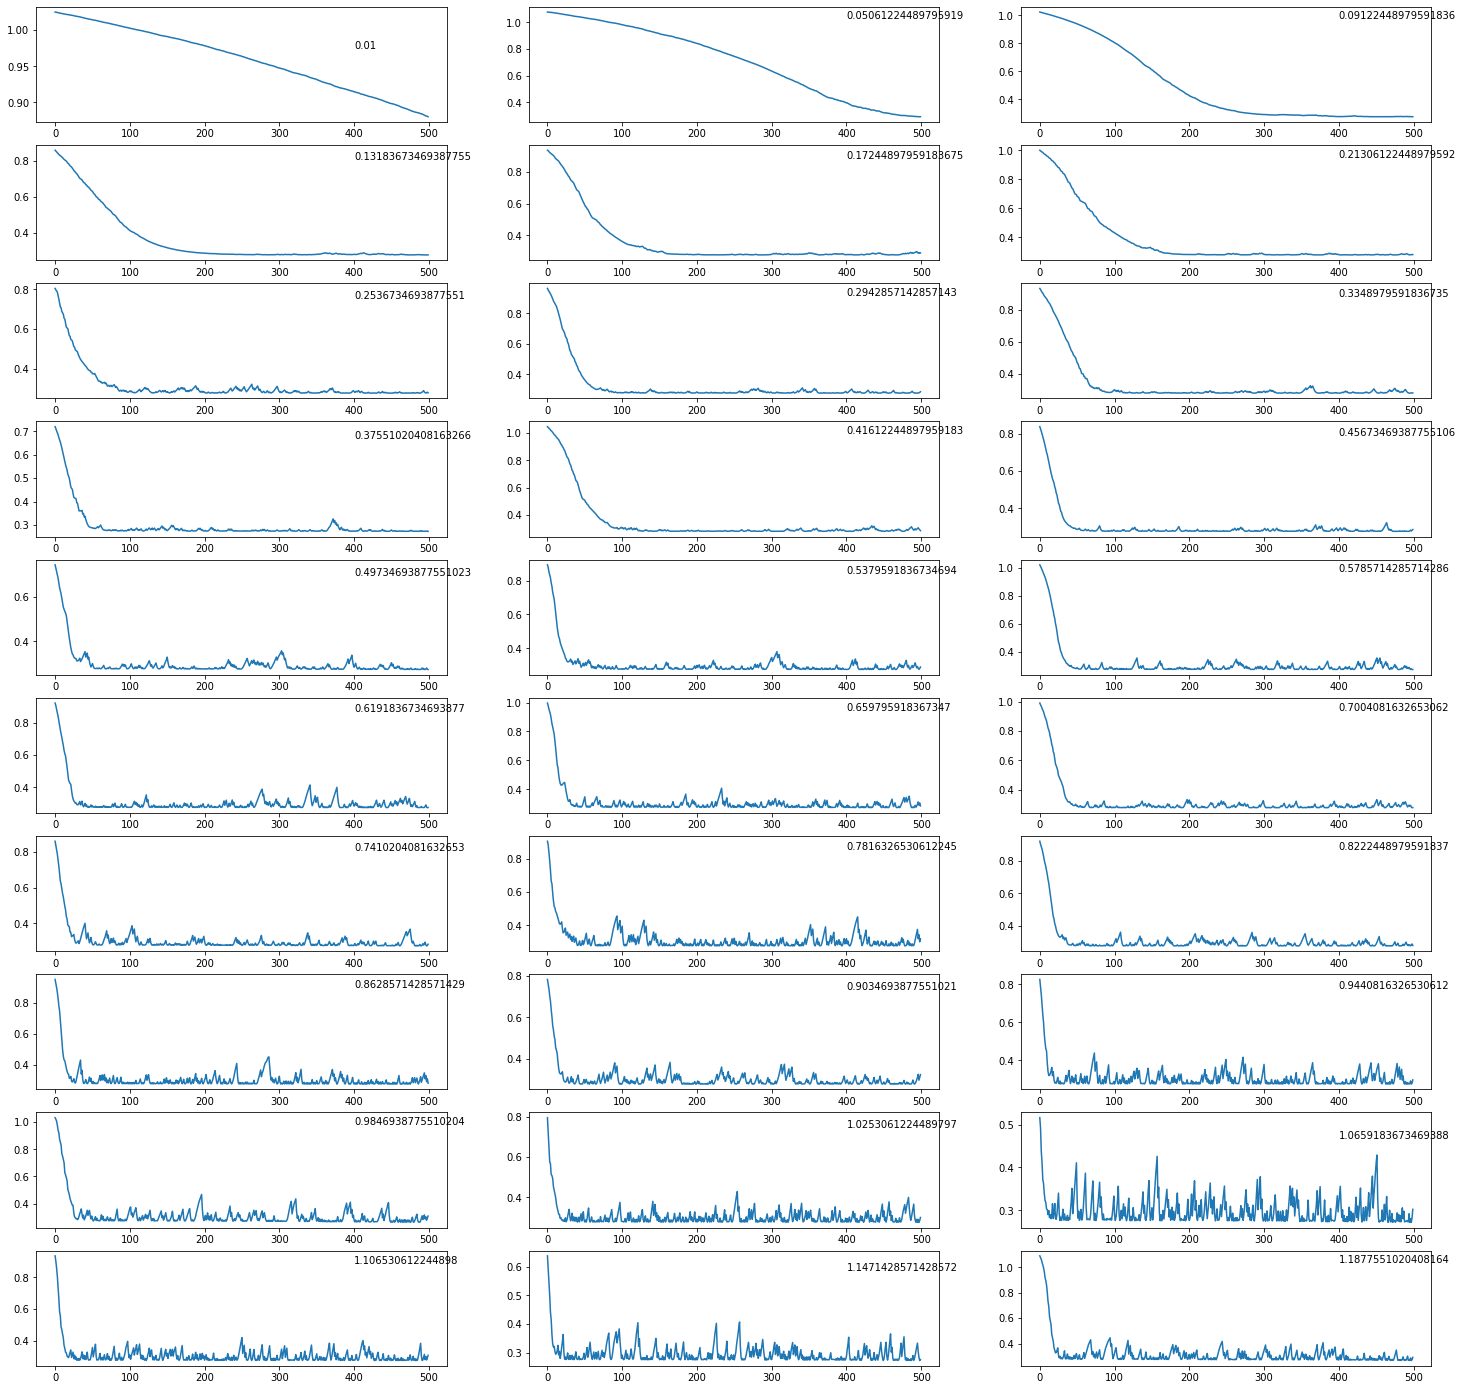

In [11]:
row = 10
col = 3
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(25, 25))
df_columns = 0
for row_i in range(0, row):
  for col_i in range(0, col):
    ax[row_i][col_i].plot(df.iloc[:,df_columns])
    ax[row_i][col_i].text(x=400, y=(max(np.array(df.iloc[:,df_columns]))-0.05), s=f"{df.columns[df_columns]}")
    df_columns += 1


## Choosing learning rate 0.13

In [12]:

# Based on the above exploration learning 1.878 is chossen because it has least covergence value
training_sets = [
    [[0, 0], [0.7, 0.3]],
    [[0, 1], [0.2, 0.8]],
    [[1, 0], [0.15, 0.85]],
    [[1, 1], [0.7, 0.3]]
]

nn = NeuralNetwork(len(training_sets[0][0]), neuraons_in_hidden_layer, neuraons_in_output_layer)
nn.update_learning_rate(0.13)
for i in range(num_of_iteration):
    training_inputs, training_outputs = random.choice(training_sets)
    nn.train(training_inputs, training_outputs)
    print(i, nn.calculate_total_error(training_sets))

0 0.8805272635888769
1 0.874103492565534
2 0.8720069570027899
3 0.8654051864086253
4 0.8633003234962088
5 0.8607446079620358
6 0.8581690503924162
7 0.8555733917763735
8 0.853410674464785
9 0.846503283640911
10 0.8397237132191177
11 0.8375714583165477
12 0.830353003181971
13 0.8282031627820855
14 0.8211270336410589
15 0.8184397878843289
16 0.8112188512028421
17 0.8035485987906544
18 0.7961036824218144
19 0.7940329181936604
20 0.7919436406403584
21 0.7892467398621192
22 0.7812870716206248
23 0.7792070380472577
24 0.7771072989204256
25 0.7690169100615015
26 0.7669428206684802
27 0.7591452206868109
28 0.7508675496766524
29 0.7425161081485971
30 0.734553244342242
31 0.7260995971111033
32 0.7237182411056997
33 0.7218867422565911
34 0.7138775854970374
35 0.7053823919419736
36 0.6968950488754807
37 0.6952497311212752
38 0.6873044244936544
39 0.6857026520982875
40 0.6772843699333821
41 0.6689325511613444
42 0.6606681424396567
43 0.6589591773184853
44 0.6572215539210121
45 0.6496203135007421
46 

In [13]:
# Plotting decision boundary is not completed

def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()